In [3]:
# Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

SyntaxError: from __future__ imports must occur at the beginning of the file (<ipython-input-3-bff099f85c3d>, line 6)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# Saves model as file
import pickle
# Verify computational environment
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
# Outlier detection
from sklearn.ensemble import IsolationForest

In [4]:
# Import data to google colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# Verify GPU
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13892430929200484823, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16690323410498343107
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15592745869904713114
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10571825691592496943
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [4]:
# Load data
path = "data/complete_data.csv"
data = pd.read_csv(path).iloc[:, 4: ]
data.head()

,price,lat,long,restaurants,shopping,vibrant,cycling_friendly,car_friendly,historic,quiet,...,powder_rooms,total_area,new_area_from_price,new_area_from_rooms,river_proximity,has_pool,n_parking,has_garage,is_devided,mr_distance
0,409000,45.5,-73.6,7.0,8.0,5.0,9.0,6.0,5.0,8.0,...,0.0,1014.0,1014.0,1014.0,False,False,1.0,True,1,5.7
1,680000,45.4,-73.6,3.0,3.0,1.0,7.0,10.0,0.0,10.0,...,0.0,1249.0,1249.0,1249.0,False,True,2.0,True,1,7.1
2,283000,45.5,-73.6,8.0,10.0,5.0,3.0,6.0,2.0,0.0,...,0.0,848.0,848.0,848.0,False,False,1.0,True,1,5.2
3,339000,45.5,-73.6,10.0,10.0,9.0,9.0,5.0,6.0,7.0,...,0.0,621.0,621.0,621.0,False,True,0.0,False,1,3.3
4,177800,45.6,-73.6,6.0,7.0,3.0,4.0,9.0,0.0,6.0,...,0.0,586.0,586.0,586.0,False,False,1.0,False,1,11.3


In [5]:
# Transform is_devided into boolean feature
data.is_devided = data.is_devided.astype('bool')

In [6]:
# # Drop redundant data
# redundant = ['more_than_$150,000_(%)', '5-person_or_more_households_(%)', 
#             'single-parent_families_(%)', 'renters_(%)', 'before_1960_(%)',
#             'mobile_homes_(%)', 'university_(%)', 'non-immigrant_population_(%)',
#             'french_(%)', 'new_area_from_price', 'new_area_from_rooms',
#             'basement_bedroom']
# data.drop(redundant, axis=1, inplace=True)

# Drop demographics data
demographics = ['less_than_$50,000_(%)', 'between_$50,000_and_$80,000_(%)', 
                'between_$80,000_and_$100,000_(%)', 'between_$100,000_and_$150,000_(%)',
                'more_than_$150,000_(%)', '1-person_households_(%)', 
                '2-person_households_(%)', '3-person_households_(%)', 
                '4-person_households_(%)', '5-person_or_more_households_(%)', 
                'couples_without_children_at_home_(%)', 'couples_with_children_at_home_(%)',
                'single-parent_families_(%)', 'owners_(%)', 'renters_(%)',
                'before_1960_(%)', 'between_1961_and_1980_(%)',
                'between_1981_and_1990_(%)', 'between_1991_and_2000_(%)',
                'between_2001_and_2010_(%)', 'between_2011_and_2016_(%)',
                'single-family_homes_(%)', 'semi-detached_or_row_houses_(%)',
                'buildings_with_less_than_5_floors_(%)',
                'buildings_with_5_or_more_floors_(%)', 'mobile_homes_(%)',
                'university_(%)', 'college_(%)', 'secondary_(high)_school_(%)',
                'apprentice_or_trade_school_diploma_(%)', 'no_diploma_(%)',
                'non-immigrant_population_(%)', 'immigrant_population_(%)',
                'french_(%)', 'english_(%)', 'others_languages_(%)',
                'new_area_from_price', 'new_area_from_rooms', 'basement_bedroom']
data.drop(demographics, axis=1, inplace=True)

In [7]:
# Remove symbols violating tf scope naming conventions
valid_column_names = [col.replace('_(%)', '').replace('$', 'CAD').
                      replace(',', '.').
                      replace('(', '').replace(')', '') for col in data.columns]
data.columns = valid_column_names
data.columns

Index(['price', 'lat', 'long', 'restaurants', 'shopping', 'vibrant',
       'cycling_friendly', 'car_friendly', 'historic', 'quiet',
       'elementary_schools', 'high_schools', 'parks', 'nightlife', 'groceries',
       'daycares', 'pedestrian_friendly', 'cafes', 'transit_friendly',
       'greenery', 'year_built', 'population_2016_',
       'population_variation_between_2011_2016_', 'population_density_',
       'unemployment_rate_2016_', 'walk_score', 'rooms', 'bedrooms',
       'bathrooms', 'powder_rooms', 'total_area', 'river_proximity',
       'has_pool', 'n_parking', 'has_garage', 'is_devided', 'mr_distance'],
      dtype='object')

In [8]:
# Random index shuffling for train/test split
df = data.copy().sample(frac=1, random_state=0)
# Prepare train and test data
train_size = round(0.8*df.shape[0])
train = df[: train_size]
test = df[train_size : ]

# Inspect training data
print('Shape of the train data with all features:', train.shape)
print("")
print("List of features:")
print(list(train.columns))

Shape of the train data with all features: (2142, 37)

List of features:
['price', 'lat', 'long', 'restaurants', 'shopping', 'vibrant', 'cycling_friendly', 'car_friendly', 'historic', 'quiet', 'elementary_schools', 'high_schools', 'parks', 'nightlife', 'groceries', 'daycares', 'pedestrian_friendly', 'cafes', 'transit_friendly', 'greenery', 'year_built', 'population_2016_', 'population_variation_between_2011_2016_', 'population_density_', 'unemployment_rate_2016_', 'walk_score', 'rooms', 'bedrooms', 'bathrooms', 'powder_rooms', 'total_area', 'river_proximity', 'has_pool', 'n_parking', 'has_garage', 'is_devided', 'mr_distance']


In [9]:
# Outlier detection
clf = IsolationForest(max_samples = 100, random_state = 0)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
# Indices of non-outliers
noano_indices = y_noano[y_noano['Top'] == 1].index.values

# Remove anomalies
train_ano_rm = train.iloc[noano_indices]
train_ano_rm.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train_ano_rm.shape[0])

Number of Outliers: 714
Number of rows without outliers: 1428


## Z-score normalization

In [10]:
boolean_features = ['river_proximity', 'has_pool',
                    'has_garage', 'is_devided']

In [11]:
# Calculate the Z-scores of each column in the training set:
train_df_mean = train_ano_rm.mean()
train_df_std = train_ano_rm.std()
train_df_norm = (train_ano_rm - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test.mean()
test_df_std = test.std()
test_df_norm = (test - test_df_mean)/test_df_std

# Add unnormalized boolean features back
for bool_feature in boolean_features:
    train_df_norm[bool_feature] = train_ano_rm[bool_feature]
    test_df_norm[bool_feature] = test[bool_feature]

## Represent data

In [12]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# We scaled all the columns, including latitude and longitude, into their
# Z scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.15  # 1.5/10 of a standard deviation.

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("lat")
latitude_boundaries = list(np.arange(int(min(train_df_norm['lat'])), 
                                     int(max(train_df_norm['lat'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("long")
longitude_boundaries = list(np.arange(int(min(train_df_norm['long'])), 
                                      int(max(train_df_norm['long'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

feature_names = data.drop(['price', 'lat', 'long'], axis=1).columns
for feature in feature_names:
    if data[feature].dtype == bool:
        train_df_norm[feature] = data[feature].astype('str') # bool raises value error
        test_df_norm[feature] = data[feature].astype('str') # bool raises value error
        categorical_feature = tf.feature_column.categorical_column_with_vocabulary_list(
            feature, ['True', 'False']
        )
        new_feature = tf.feature_column.indicator_column(categorical_feature)
    else:
        new_feature = tf.feature_column.numeric_column(feature)
    feature_columns.append(new_feature)

# Convert list of feature columns into a layer that will be fed into the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Plotting functionality

In [13]:
def plot_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_loss_curve function.")

Defined the plot_loss_curve function.


## Linear Regression model

In [14]:
def create_model(my_learning_rate, feature_layer, l2=0):
    """Create and compile a linear regression model with l2 regularization."""
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(feature_layer)

    # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                    kernel_regularizer=tf.keras.regularizers.l2(l2)))

    # Construct the layers into a model that TensorFlow can execute.
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model           


def train_model(model, dataset, epochs, batch_size, label_name):
    """Feed a dataset into the model in order to train it."""

    # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                        epochs=epochs, shuffle=True)

    # Get details that will be useful for plotting the loss curve.
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    rmse = hist["mean_squared_error"]

    return epochs, rmse   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


sor 'ExpandDims_28:0' shape=(None, 1) dtype=float32>, 'bedrooms': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float32>, 'bathrooms': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float32>, 'powder_rooms': <tf.Tensor 'ExpandDims_24:0' shape=(None, 1) dtype=float32>, 'total_area': <tf.Tensor 'ExpandDims_30:0' shape=(None, 1) dtype=float32>, 'river_proximity': <tf.Tensor 'ExpandDims_27:0' shape=(None, 1) dtype=string>, 'has_pool': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=string>, 'n_parking': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=float32>, 'has_garage': <tf.Tensor 'ExpandDims_9:0' shape=(None, 1) dtype=string>, 'is_devided': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=string>, 'mr_distance': <tf.Tensor 'ExpandDims_16:0' shape=(None, 1) dtype=float32>}
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2/2 [==============================] - 0s 4ms/step - loss: 1.6994 - mean_squared_error: 1.488

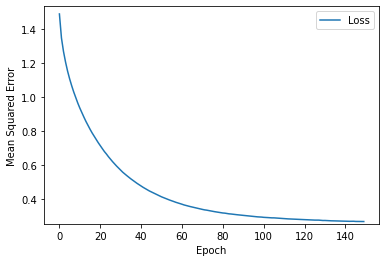


 Evaluate the linear regression model against the test set:
Consider rewriting this model with the Functional API.
1/1 [==============================] - 0s 5ms/step - loss: 0.3409 - mean_squared_error: 0.3041


[0.34086689352989197, 0.3041191101074219]

In [15]:
# Hyperparameters.
learning_rate = 0.002
epochs = 150
batch_size = 1000
l2 = 0.1
label_name = "price"

# Establish the model's topography.
my_linear_model = create_model(learning_rate, my_feature_layer, l2)

# Train the model on the normalized training set.
epochs, mse = train_model(my_linear_model, train_df_norm, epochs, batch_size, label_name)
plot_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_linear_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

Data including demographics:   
**Training:** loss: 0.2409 - mean_squared_error: 0.2409   
**Validation:** loss: 0.4419 - mean_squared_error: 0.4419
  
---

Data excluding demographics:   
**Training:** loss: 0.2290 - mean_squared_error: 0.2290    
**Validation:** loss: 0.3215 - mean_squared_error: 0.3215  

---

The linear model appears to perform better without the demographic data. The
difference between training and validation metrics remains rather large. More stringent regularization may be advisable.

---

After Regularization of model with data excluding demographics:  
**Training:** loss: 0.3113 - mean_squared_error: 0.2792  
**Validation:** loss: 0.3497 - mean_squared_error: 0.3178

In [16]:
# Z-score conversion to $
test_mse = my_linear_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)[1]
test_mse * train_df_std.price

1/1 [==============================] - 0s 1ms/step - loss: 0.3409 - mean_squared_error: 0.3041


56778.79468936736

## Deep neural net model

In [56]:
def create_model(my_learning_rate, my_feature_layer, n_layers, n_nodes):
    """Create and compile a simple linear regression model.
  
    Args:
    my_learning_rate - integer representing learning rate
    my_feature_layer - tf feature columns
    n_layers - integer indicating the number of layers
    n_nodes - list of integers, indicating the number of nodes for each leayer.
        len(n_nodes) must be n_layers
    """

    # Stop if n_nodes as less or more elements than there are layers
    if len(n_nodes) != n_layers:
        print("n_nodes must be of length n_layers!")
        return None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.


    # Define layers and nodes
    for layer in range(n_layers):
        nodes = n_nodes[layer]
        name = 'Hidden' + str(layer)
        # Define hidden layer with n nodes.   
        model.add(tf.keras.layers.Dense(units=nodes, 
                                        activation='tanh',
                                        kernel_regularizer=tf.keras.regularizers.l2(0.2), 
                                        name=name)) 
        # # Dropout layer
        # model.add(tf.keras.layers.Dropout(rate=0.2))

    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1,  
                                    name='Output'))                              

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

    return model

In [40]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None):
    """Train the model by feeding it data."""

    # Split the dataset into features and label.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                        epochs=epochs, shuffle=True) 

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch. 
    hist = pd.DataFrame(history.history)
    mse = hist["mean_squared_error"]

    return epochs, mse

Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2/2 [==============================] - 0s 6ms/step - loss: 5.8297 - mean_squared_error: 1.0439
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 5.6231 - mean_squared_error: 0.9587
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 5.4287 - mean_squared_error: 0.8834
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 5.2473 - mean_squared_error: 0.8190
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 5.0791 - mean_squared_error: 0.7661
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 4.9207 - mean_squared_error: 0.7213
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 4.7710 - mean_squared_error: 0.6835
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 4.6291 - mean_squared_error: 0.6521
Epoch 9/100
2/2 [=================

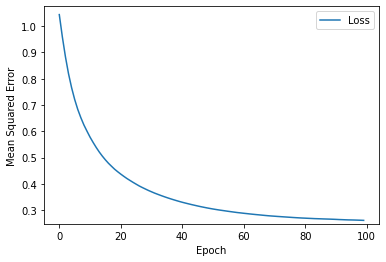


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
1/1 [==============================] - 0s 7ms/step - loss: 0.5022 - mean_squared_error: 0.2951


[0.5022090077400208, 0.295091837644577]

In [60]:
# Hyperparameters.
learning_rate = 0.001
epochs = 100
batch_size = 1000
n_layers = 1
n_nodes = [13]

# Specify the label
label_name = "price"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer, n_layers, n_nodes)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

In [29]:
# Node tuning
learning_rate = 0.0015
epochs = 100
batch_size = 1000
n_layers = 1
n_nodes = [[25], [15], [10]]

# Test data
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label

average_mses = []
for nodes in n_nodes:
    mse_simulation = []
    # 10 simulations for each node hyperparamter
    for i in range(10):
        # Specify the label
        label_name = "price"

        # Establish the model's topography.
        my_model = create_model(learning_rate, my_feature_layer, n_layers, nodes)

        # Train the model on the normalized training set. We're passing the entire
        # normalized training set, but the model will only use the features
        # defined by the feature_layer.
        epoch, mse = train_model(my_model, train_df_norm, epochs, 
                                label_name, batch_size)
        
        # After building a model against the training set, test that model
        # against the test set.
        print("\n Evaluate the new model against the test set:")
        mse = my_model.evaluate(x = test_features, 
                                y = test_label, 
                                batch_size=batch_size)[1]
        mse_simulation.append(mse)                        
        print('Training MSE:', mse)
        print('+'*75)
    average_mse = np.array(mse_simulation).mean()
    average_mses.append(average_mse)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step - loss: 1.7202 - mean_squared_error: 0.2691
Epoch 44/100
2/2 [==============================] - 0s 5ms/step - loss: 1.6325 - mean_squared_error: 0.2685
Epoch 45/100
2/2 [==============================] - 0s 5ms/step - loss: 1.5496 - mean_squared_error: 0.2679
Epoch 46/100
2/2 [==============================] - 0s 5ms/step - loss: 1.4714 - mean_squared_error: 0.2673
Epoch 47/100
2/2 [==============================] - 0s 6ms/step - loss: 1.3975 - mean_squared_error: 0.2664
Epoch 48/100
2/2 [==============================] - 0s 5ms/step - loss: 1.3283 - mean_squared_error: 0.2661
Epoch 49/100
2/2 [==============================] - 0s 7ms/step - loss: 1.2630 - mean_squared_error: 0.2654
Epoch 50/100
2/2 [==============================] - 0s 5ms/step - loss: 1.2014 - mean_squared_error: 0.2646
Epoch 51/100
2/2 [==============================] - 0s 5ms/step - loss: 1.1433 - mean_squared_erro

In [30]:
print('Average mses for number of nodes:')
for i in range(len(n_nodes)):
    print(n_nodes[i], 'number of nodes: average mse =', average_mses[i])

Average mses for number of nodes:
[25] number of nodes: average mse = 0.30434403121471404
[15] number of nodes: average mse = 0.30513900220394136
[10] number of nodes: average mse = 0.3056473046541214


One layer performs best, with similar results using ReLu and Tanh activation.
There doesn't seem to be a significant diffence in the performance of the linear and non linear nets. The simpler model will therefore be chose.

In [18]:
filename = 'tf_linear_model.sav'
pickle.dump(my_linear_model, open(filename, 'wb'))

AttributeError: Can't pickle local object 'WeakSet.__init__.<locals>._remove'